# The force applied on a stone in the Yvette river

Chensheng LUO (Sofiane),  
Student at CentraleSupélec    
GitHub account: [*lcs27*](https://github.com/lcs27)   
Contact: chensheng-sofiane.luo@student-cs.fr   
***ATTENTION!***
To be able to perform all of the calculate in this file, the following package are needed, which can be installed by *Anaconda*.
- ```math```
- ```dolfin``` and ```fenics```
- ```matplotlib.pyplot```
- ```numpy```
- ```mshr```   
- ```scipy```
- ```requests```

If you don't have the corresponding module, some error message may occur.   
A precalculated version is availiable in [this GitHub link](https://github.com/lcs27/cours-edp/blob/master/project/EDP_Project.ipynb) and you can see the result even if you don't have all the module.

## Description of the model

<!-- 10 lines max -->
Imagine a cylinder stone in the Yvette river. To judge whether it will be washed away, we calculate the force $F$ applied on it. Besides, it's interesting to study the change of velocity in the river due to the stone. With fluid mechanics, the velocity of the fluid ($\vec{u}$) can be described by the famous Navier-Stokes equation [1]:
\begin{equation}\tag{NS}
\rho \frac{D \vec{u}}{D t}=-\nabla p+\mu \nabla^{2} \vec{u}+\frac{1}{3}\mu \nabla (\nabla \cdot \vec{u})+\rho \vec{g}
\end{equation}

The following assumption is made to simplify the equation:
- the fluid is incompressible($\nabla \cdot \vec{u}= 0$) 
- we calculate in the steady state with a low Renold number($Re<<1$) such that $\frac{D \vec{u}}{D t}=0$
- the gravity is negliged($\vec{g}=\vec{0}$) and we study in 2D, with the height of the stone $H=1m$


As the river is long, we make two fictitious sections($AD$,$BC$) on the river to study this problem in a 2D rectangle with a circle in center as the stone($\Omega$). 
<img src="https://raw.githubusercontent.com/lcs27/cours-edp/main/project/domaine.jpg" alt="The domained studied" width="500" height="313" align="bottom" />
At the border of the river($AB$, $CD$) and of the stone($\partial\Sigma$), the velocity of the fluid is zero ($\vec{u}=\vec{0}$, no-slip condition). The two fictitious sections are supposed to be at infinity and the velocity $\vec{u}=U_{0}\frac{4y(H-y)}{H^{2}}\vec{e_{x}}$, with $U_{0}$ a random variable. The position $Y$ is also a random variable.

## Equation

### PDE

<!-- 20 lines max -->
With the assumption above, we can simplify the equation **(NS)** to the following equations.This kind of flow is called **Stokes flow** [2].

\begin{equation}
\begin{cases}
\nabla p=\mu \nabla^{2} \vec{u}\\
\nabla \cdot \vec{u}=0
\end{cases}
\end{equation}
where $p$ is the pressure, $\mu$ is the viscosity for the fluid and $\vec{u}$ is the velocity.

By taking the reference length $L_{ref}=1m$, the reference velocity $V_{ref}=1m/s$, the reference pressure $P_{ref}=1Pa$, we can get the dimensionless equation
\begin{equation}
\begin{cases}
\nabla \widetilde{p}=\widetilde{\mu} \nabla^{2} \vec{\widetilde{u}}\\
\nabla \cdot \vec{\widetilde{u}}=0
\end{cases}
\end{equation}
with $\widetilde{\mu}=\frac{\mu V_{ref}}{L_{ref} P_{ref}}$ , $\widetilde{p}=\frac{p}{P_{ref}}$, $\widetilde{u}=\frac{u}{V_{ref}}$ and $\widetilde{x}=\frac{x}{L_{ref}}$ etc.
By considering the boudary conditions, we have
\begin{equation}
\tag{S}
\begin{cases}
\begin{cases}
\nabla \widetilde{p}=\widetilde{\mu} \nabla^{2} \vec{\widetilde{u}} \qquad (S_{1})\\
\nabla \cdot \vec{\widetilde{u}}=0 \qquad (S_{2})
\end{cases}\\
(CL)
\begin{cases}
\vec{\widetilde{u}}=\widetilde{U}_{0}\vec{e_{x}} \quad \mbox{on}\ AD, BC \\
\vec{\widetilde{u}}=0 \quad \mbox{on}\ AB, CD,\partial \Sigma
\end{cases}
\end{cases}
\end{equation}
For the equation above, we take the viscosity of water at $298K$, we have $\widetilde{\mu}=8.9\times 10^{-4}$[3]. For the velocity at infinit, we take $\widetilde{U}_{0}=\frac{U_{0}}{V_{ref}} \sim N(5, 0.1)$

### Variational formula

From this part, we omit the notation $\widetilde{\cdot}$ and take $u$ to be $\widetilde{u}$.  
Let's considering the test function $(\vec{v},q) \in H^{1}_{0}(\Omega) \times L^{2}_{0}(\Omega)$ [4] By intergration by part and by adding this to equation, we have: 
\begin{equation}
\int_{\Omega} (-\mu  \nabla \vec{u} : \nabla \vec{v} + p  \nabla\cdot\vec{v}+ q \nabla \cdot \vec{u})dx= 0
\end{equation} 
Thus, we have the bilinear form: $a((\vec{u},p),(\vec{v},q))= \int_{\Omega} -\mu  \nabla \vec{u} : \nabla \vec{v} + p  \nabla\cdot\vec{v}+ q \nabla \cdot \vec{u}$ and the linear forms: $f((\vec{v},q))=0$
We can prove that $a$ is continous and coercive and obviously $f$ is continuous.

### preconditioner 

According to [5], a preconditionner should be made as
\begin{equation}
b((\vec{u},p),(\vec{v},q))= \int_{\Omega} (-\mu  \nabla \vec{u} : \nabla \vec{v} + p  q)dx
\end{equation}

## Simulation-Conclusion

### Basic functions and defaut solution

We first define the necessary functions:  ```solve_stokes``` is the FEniCS solver to solve function, ```plot_field``` is the function to draw a field and ```calculate_force``` is a function to calculate the force applied on the stone with $\vec{F}=Z\int_{\partial \Sigma} p \vec{n}\cdot\vec{e_{x}}ds$.

In [1]:
import math
from dolfin import *
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
from mshr import *
# To enter an interactive mode, please uncomment the following line
#%matplotlib notebook

In [2]:
def solve_stokes(X=10,Y=3,U0=5,phi=1,nx=100):
    '''
    The FEniCS solver used to solve this question for 
    
    Input
    ----------------------
    - (X,Y) the position of the stone dropped, predefined to be the center, default to be (10,3)
    - U0 velocity of the river, defaut to be 5
    - phi the diameter of the stone, defaut to be 1
    
    Output
    ----------------------
    - u, the velocity field(vector field)
    - p, the pressure field(scalar field)
    - V, the space of u
    - Q, the space of p
    - W, the space V*Q
    - mesh, the mesh of the field
    - boundary_subdomains, the boundary subdomains
    '''
    # Scaled variables
    D = 20; H = 6; mu =8.9*1e-4
    nx = 500; order = 1

    # Create mesh and define function space
    base = Rectangle(Point(0, 0), Point(D, H))
    hole = Circle(Point(X, Y), phi/2)
    mesh = generate_mesh(base - hole, nx)

    # Define the mixed function space
    Element1 = VectorElement('P', mesh.ufl_cell(), order)
    Element2 = FiniteElement( 'P', mesh.ufl_cell(), order)
    W_elem = MixedElement([Element1, Element2])
    V = FunctionSpace(mesh,Element1)
    Q = FunctionSpace(mesh,Element2)
    W = FunctionSpace(mesh, W_elem)

    # Define boundary condition
    tol = 1E-10

    inflow =Expression(('A*4*x[1]*(B-x[1])/B/B','0'),A=U0,B=H,degree=2)
    def left_right_boundary(x, on_boundary):
        return on_boundary and (abs(x[0])<tol or abs(x[0] - D)<tol)
    bc_LR = DirichletBC(W.sub(0), inflow ,left_right_boundary)

    def top_bottom_boundary(x, on_boundary):
        return on_boundary and (abs(x[1])<tol or abs(x[1] - H)<tol)
    bc_TB = DirichletBC(W.sub(0), Constant((0,0)),top_bottom_boundary)

    def circle_boundary(x, on_boundary):
        r = math.sqrt((x[0]-X)*(x[0]-X)+(x[1]-Y)*(x[1]-Y))
        return on_boundary and abs(r-phi/2)<(0.5/nx)
    bc_CR = DirichletBC(W.sub(0), Constant((0,0)),circle_boundary)

    bc = [bc_LR,bc_TB,bc_CR]
    
    # Define boundary subdomaines
    boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_subdomains.set_all(0)
    AutoSubDomain(left_right_boundary).mark(boundary_subdomains, 1)
    AutoSubDomain(top_bottom_boundary).mark(boundary_subdomains, 2)
    AutoSubDomain(circle_boundary).mark(boundary_subdomains, 3)

    # Define variational formula
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)
    a = -mu*inner(grad(u), grad(v))*dx + div(v)*p*dx + q*div(u)*dx
    f = inner(Constant((0, 0)), v)*dx

    # Construction of preconditioner matrix
    b = -mu*inner(grad(u), grad(v))*dx + p*q*dx
    A, bb = assemble_system(a, f, bc)
    P, btmp = assemble_system(b, f, bc)
    solver = KrylovSolver("tfqmr", "amg")
    solver.set_operators(A, P)

    # Solve
    U = Function(W)
    solver.solve(U.vector(), bb)
    u, p = U.split()
    u = project(u,V)
    p = project(p,Q)
    return u,p,V,Q,W,mesh,boundary_subdomains

def plot_field(u,mesh,tit='',labelx='',labely=''):
    '''
    To plot a field(scalar or vector)
    
    Input
    ----------------------
    - u, the field
    - mesh, the mesh of the domaine
    - tit, the title, default to be vide string
    - labelx, the xlabel, default to be vide string
    - labely, the ylabel, default to be vide string
    '''
    plt.figure()
    plot(mesh,alpha=0.05)
    plu=plot(u)
    plt.colorbar(plu,fraction=0.2, pad=0.04)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(tit)

def calculate_force(p,mesh,boundary_subdomains,Z=1):
    '''
    To calculate the force applied on the stone
    
    Input
    ------------------
    - p, the pressure field
    - mesh, the mesh of the domaine
    - boundary_subdomains
    - Z, the height of the stone, defaut to be 1
    
    Output
    ------------------
    - force, the force on the stone
    '''
    dss = ds(subdomain_data=boundary_subdomains)
    n = FacetNormal(mesh)
    ex  = Constant((1,0))
    f = p*dot(n, ex)* dss(3)
    force = Z*assemble(f)
    return force

Let's first calculate the result for a defaut parameter ($X=10,Y=3,U_{0}= 5,\phi=1$).

The force applied on the stone is  0.038533730889636075 .
The maximum of velocity is  5.738281848367528 .


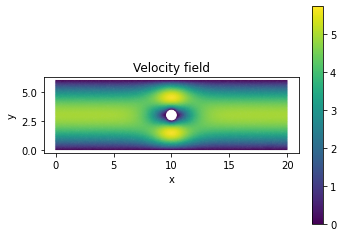

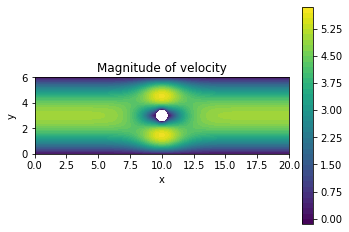

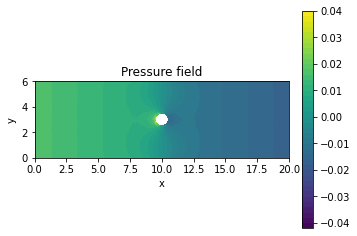

In [3]:
u,p,V,Q,W,mesh,boundary_subdomains = solve_stokes(nx=100)

plot_field(u,mesh,tit='Velocity field',labelx='x',labely='y')

u_mag=sqrt(dot(u,u))
u_mag=project(u_mag,FunctionSpace(mesh,'P',1))
u_array=np.array(u_mag.vector())

plot_field(u_mag,mesh,tit='Magnitude of velocity',labelx='x',labely='y')
plot_field(p,mesh,tit='Pressure field',labelx='x',labely='y')
print('The force applied on the stone is ',calculate_force(p,mesh,boundary_subdomains),'.')
print('The maximum of velocity is ',np.max(u_array),'.')

**Conclusion:** We can then conclude that the force applied on the stone is $F=0.039N$ , which is quite small so it's difficult to wash away it. What's more, there is a small augmentation of velocity around the object, with the maximum increase of velocity $\Delta V_{max}=V_{max}-U_{0}=0.73m/s$.

### Case 1: The influence of velocity

Let's study the influence of $U_{0}$ and make it a random variable, with $U_{0} \sim N(5,1)$ and we study the impact on $F$ and $V_{max}$.    


In [4]:
def study_velocity():
    '''
    To generate 200 random samples to study the influence of velocity
    
    WARNING! This calculate may take more than 6h as nx=1000 is needed to have a precise result, 
    a precalculated result is availiable on https://github.com/lcs27/cours-edp/tree/master/project/results, 
    with calculate details on https://github.com/lcs27/cours-edp/actions
    '''
    sample_Num = 200
    U0s = np.random.normal(5, 1, sample_Num)
    force1 = []
    max_velocity1 = []

    ### For each sample, calculate the velocity and pressure field
    k = 1
    for U in U0s:
        # Get the field
        u,p,V,Q,W,mesh,boundary_subdomains = solve_stokes(U0=U,nx=1000)
    
        # Get the magnitude of velocity
        u_mag=sqrt(dot(u,u))
        u_mag=project(u_mag,FunctionSpace(mesh,'P',1))
        u_array=np.array(u_mag.vector())
    
        # Get the force and max of velocity
        force1.append(calculate_force(p,mesh,boundary_subdomains))
        max_velocity1.append(np.max(u_array))
    
        # We can see the progression
        print(k,end=',')
        k += 1


***Attention!*** To find the law behind this question, a precise calculate is needed with ```nx=1000```. It may take more than 20 hours in total, so a [result](https://github.com/lcs27/cours-edp/tree/master/project/results) is precalculated by using [GitHub Action](https://github.com/lcs27/cours-edp/actions)(click for details) and multi-tasking. The function ```result_U0``` is to get it from GitHub, the same for ```result_phi```  and ```result_Y``` .

In [5]:
import requests as req

def result_U0():
    '''
    To get the precalculated results from GitHub
    
    Output
    ------------------
    - U0s,force, max_velocity, the corresponding results
    '''
    U0s = []
    force = []
    max_velocity = []
    for i in range(1,11):
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/U0s'+str(i)+'.txt')
        U0s = np.concatenate((U0s,np.fromstring(res.text, dtype=float,sep='\n')))
    
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/force_U0s'+str(i)+'.txt')
        force = np.concatenate((force,np.fromstring(res.text, dtype=float,sep='\n')))
        
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/max_velocity_U0s'+str(i)+'.txt')
        max_velocity = np.concatenate((max_velocity,np.fromstring(res.text, dtype=float,sep='\n')))
    return U0s, force, max_velocity

We define the following function to better process our data, with ```histogram``` to plot histogram and ```relationship``` to find the relationship of two array.

In [6]:
import scipy.stats as st
def histogram(A,name='',approximation=2):
    '''
    To plot the histogram of a random variable
    
    Input
    ------------------
    - A, the numpy array to be plotted
    - name, the name to write on the histogram
    - approximation, the order of approximation
    '''
    plt.figure()
 
    n, bins, patches = plt.hist(A, len(A), density=1, color='blue',alpha = 0.2,label='Histogram')  
    mu =np.mean(A)# The avarage
    sigma =np.std(A) # The variance
    plt.grid(True)
    y = st.norm.pdf(bins, mu, sigma)# The normal distribution with this result
    fig=plt.plot(bins, y,'r--',label='Normal Distribution')
    plt.xlabel(name) 
    if name != '':
        plt.title('Histogram of '+name+':$\mu$=' + str(round(mu,approximation)) + ' $\sigma=$'+str(round(sigma,approximation))) 
    else:
        plt.title('Histogram:$\mu$=' + str(round(mu,approximation)) + ' $\sigma=$'+str(round(sigma,approximation))) 
    plt.legend()
    plt.show()
    
def relationship(X,Y,plotr=True,xname='',yname=''):
    '''
    To find the linear regression of two array and plot them
    
    Input
    ------------------
    - X, Y, the array to find relationship with
    - plotr, whether plot the regression line, defalut to be true
    - xname, yname, the name of two array, default to be ''
    
    Output
    - slope, intercept, r_value, p_value, std_err, the elements of the linear regression
    '''
    slope, intercept, r_value, p_value, std_err = st.linregress(X, Y)
    plt.figure()
    a = plt.scatter(X,Y,c = 'r',marker = 'o',label='Numerical Result')
    plt.grid(True)
    plt.xlabel(xname) 
    plt.ylabel(yname) 
    if xname != '' and yname != '':
        plt.title(yname+'-'+xname) 
    if plotr == True:
        x = np.arange(min(X),max(X),(max(X)-min(X))/100);
        y = x * slope + intercept
        b = plt.plot(x,y,label='Regression Line')
    plt.legend()
    plt.show()

    return slope, intercept, r_value, p_value, std_err 

We study in the following part the its distribution and the relationship between variables.

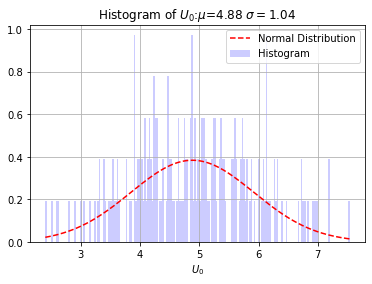

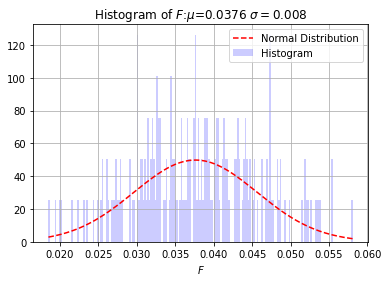

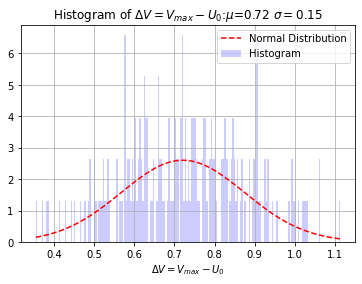

In [7]:
U0s, force, max_velocity = result_U0()

histogram(U0s,name='$U_{0}$')
histogram(force,name='$F$',approximation=4)
histogram(max_velocity-U0s,name='$\Delta V=V_{max}-U_{0}$')

 **Conclusion** In the graph above we can se the distribution of $F$ and $V_{max}$, who follows bothglobaly a normal distribution.We can see that a fluctation of $1m/s$ in velocity can lead to a maximum force of about $0.06N$ and a velocity augmentation of water for about $1m/s$. As the force is so small, it's of a possibility $\mathbb{P}\sim 0 $that the stone will be washed away.

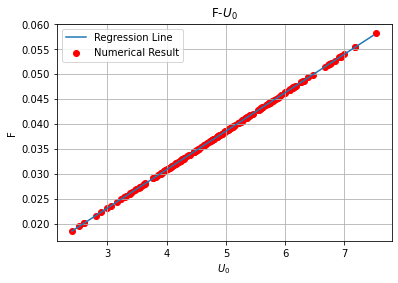

The linear regression of F-U0 is F= 0.007706746177966432 U0+ 1.4065137943219952e-14 with R^2= 0.9999999999999996


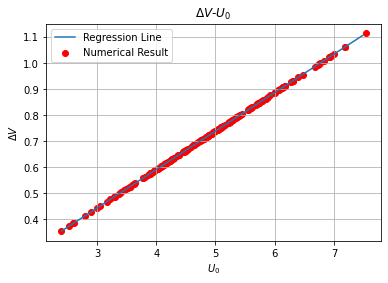

The linear regression of delta_V-U0 is deltaV= 0.14765636967339932 U0+ 2.426947531830592e-13 with R^2= 0.9999999999999993


In [8]:
slope, intercept, r_value,_,_=relationship(U0s,force,xname='$U_{0}$',yname='F')
print('The linear regression of F-U0 is F=',str(slope),'U0+',str(intercept),'with R^2=',str(r_value))
slope, intercept, r_value,_,_=relationship(U0s,max_velocity-U0s,xname='$U_{0}$',yname='$\Delta V$')
print('The linear regression of delta_V-U0 is deltaV=',str(slope),'U0+',str(intercept),'with R^2=',str(r_value))

 **Conclusion** In the graph above, we can see the the relationship of $U_{0}$- $F$,and $U_{0}$ - $\Delta V$. As $R^{2}\approx 1$ and $intercept\approx 0$. We can observe that $F\propto U_{0}$ and $\Delta V \propto U_{0}$, with the numerical formula $F\approx 0.0077 U_{0}$ and $\Delta V \approx 0.15 U_{0}$. So a very big velocity is needed to have a force no negligeable.

### Case 2: The influence of diameter

Let's study the influence of $\phi$ and make it a random variable, with $\phi \sim N(1,0.25)$ and we study the impact on $F$ and $V_{max}$.    

In [9]:
def study_diameter():
    '''
    WARNING! This calculate may take more than 6h as nx=1000 is needed to have a precise result, 
    a precalculated result is availiable on https://github.com/lcs27/cours-edp/tree/master/project/results, 
    with calculate details on https://github.com/lcs27/cours-edp/actions
    '''
    sample_Num = 200
    phis = np.random.normal(1, 0.25, sample_Num)
    force2 = []
    max_velocity2 = []

    ### For each sample, calculate the velocity and pressure field
    k = 1
    for phi in phis:
        # Get the field
        u,p,V,Q,W,mesh,boundary_subdomains = solve_stokes(phi=phi,nx=1000)
    
        # Get the magnitude of velocity
        u_mag=sqrt(dot(u,u))
        u_mag=project(u_mag,FunctionSpace(mesh,'P',1))
        u_array=np.array(u_mag.vector())
    
        # Get the force and max of velocity
        force2.append(calculate_force(p,mesh,boundary_subdomains))
        max_velocity2.append(np.max(u_array))
    
        # We can see the progression
        print(k,end=',')
        k += 1

In [10]:
import requests as req

def result_phi():
    '''
    To get the precalculated results from GitHub
    
    Output
    ------------------
    - phis,force, max_velocity, the corresponding results
    '''
    phis = []
    force = []
    max_velocity = []
    for i in range(1,11):
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/phis'+str(i)+'.txt')
        phis = np.concatenate((phis,np.fromstring(res.text, dtype=float,sep='\n')))
    
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/force_phis'+str(i)+'.txt')
        force = np.concatenate((force,np.fromstring(res.text, dtype=float,sep='\n')))
        
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/max_velocity_phis'+str(i)+'.txt')
        max_velocity = np.concatenate((max_velocity,np.fromstring(res.text, dtype=float,sep='\n')))
    return phis, force, max_velocity

We study in the following part the its distribution and the relationship between variables.

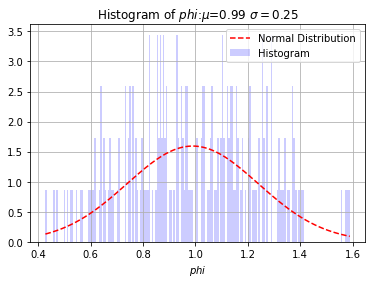

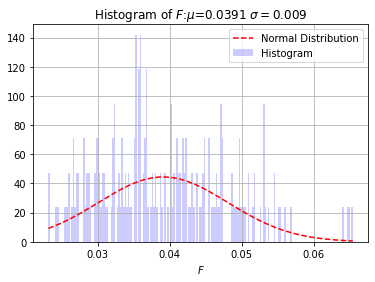

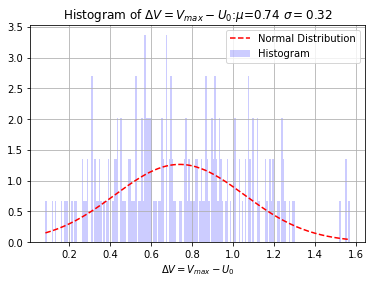

In [11]:
phis, force, max_velocity = result_phi()
U0=5

histogram(phis,name='$phi$')
histogram(force,name='$F$',approximation=4)
histogram(max_velocity-U0,name='$\Delta V=V_{max}-U_{0}$')

 **Conclusion** In the graph above we can se the distribution of $F$ and $\Delta V$. Even though the diameter have a distribution symetric, the distribution of $F$ and $\Delta V$ is not symetric,and with a variance bigger. However, for small stones, the force is not so small.

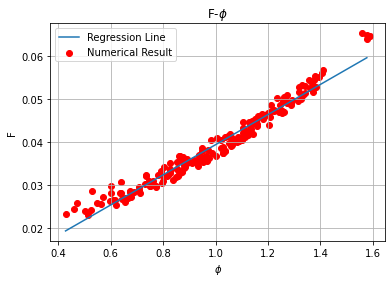

The linear regression of F-phi is F= 0.03511016728591687 phi+ 0.004334161912545341 with R^2= 0.9798609693517446


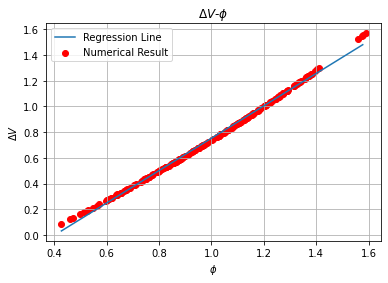

The linear regression of deltaV-phi is deltaV= 1.2603912694250625 phi+ -0.5077443616572285 with R^2= 0.9985268612376987


In [12]:
slope, intercept, r_value,_,_=relationship(phis,force,xname='$\phi$',yname='F')
print('The linear regression of F-phi is F=',str(slope),'phi+',str(intercept),'with R^2=',str(r_value))
slope, intercept, r_value,_,_=relationship(phis,max_velocity-U0,xname='$\phi$',yname='$\Delta V$')
print('The linear regression of deltaV-phi is deltaV=',str(slope),'phi+',str(intercept),'with R^2=',str(r_value))

 **Conclusion** In the graph above we can see the the relationship of $\phi$- $F$,and $\phi$ - $\Delta V$. As $R^{2}\approx 1$  there exists a linear relation, but the intercept is not zero, which seems to be strange (if there is no object, nothing should happen).So the linear relation is only suitable for a certain diameter(not so small and no so big in front of $H$). And we can have the numerical formula $F\approx 0.035 \phi+ 0.004$ and $\Delta V \approx 1.260 \phi - 0.508$ $(\phi \sim 1)$. As $\frac{F}{\phi}$ increase with $\phi$, if the stone is small enough, it can be washed away, which is quiet logical according to our daily life.

### Case 3: The influence of position

The variation of $X$ is of no sense (as the river is long) so we make $Y$ a random variable, with $Y \sim N(3,0.5)$ and we study the impact of position.

In [13]:
def study_position():
    '''
    WARNING! This calculate may take more than 6h as nx=1000 is needed to have a precise result, 
    a precalculated result is availiable on https://github.com/lcs27/cours-edp/tree/master/project/results, 
    with calculate details on https://github.com/lcs27/cours-edp/actions
    '''
    sample_Num = 200
    Ys = np.random.normal(3, 0.5, sample_Num)
    force3 = []
    max_velocity3 = []

    ### For each sample, calculate the velocity and pressure field
    k = 1
    for Y in Ys:
        # Get the field
        u,p,V,Q,W,mesh,boundary_subdomains = solve_stokes(Y=Y,nx=1000)
    
        # Get the magnitude of velocity
        u_mag=sqrt(dot(u,u))
        u_mag=project(u_mag,FunctionSpace(mesh,'P',1))
        u_array=np.array(u_mag.vector())
    
        # Get the force and max of velocity
        force3.append(calculate_force(p,mesh,boundary_subdomains))
        max_velocity3.append(np.max(u_array))
    
        # We can see the progression
        print(k,end=',')
        k += 1

In [14]:
import requests as req

def result_Y():
    '''
    To get the precalculated results from GitHub
    
    Output
    ------------------
    - Ys,force, max_velocity, the corresponding results
    '''
    Ys = []
    force = []
    max_velocity = []
    for i in range(1,11):
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/Ys'+str(i)+'.txt')
        Ys = np.concatenate((Ys,np.fromstring(res.text, dtype=float,sep='\n')))
    
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/force_Ys'+str(i)+'.txt')
        force = np.concatenate((force,np.fromstring(res.text, dtype=float,sep='\n')))
        
        res = req.get('https://raw.githubusercontent.com/lcs27/cours-edp/master/project/results/max_velocity_Ys'+str(i)+'.txt')
        max_velocity = np.concatenate((max_velocity,np.fromstring(res.text, dtype=float,sep='\n')))
    return Ys, force, max_velocity

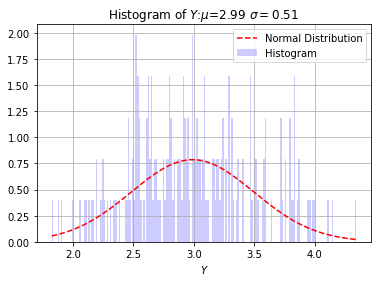

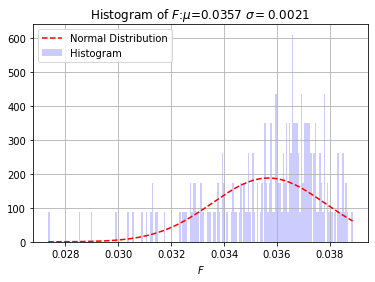

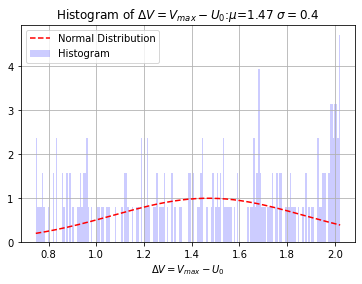

In [15]:
Ys, force, max_velocity = result_Y()
U0=5

histogram(Ys,name='$Y$')
histogram(force,name='$F$',approximation=4)
histogram(max_velocity-U0,name='$\Delta V=V_{max}-U_{0}$')

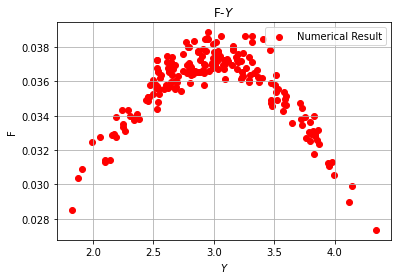

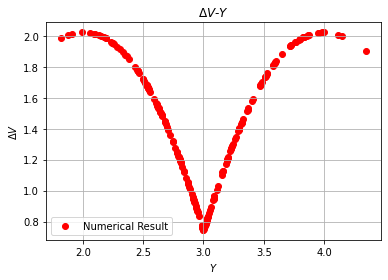

In [16]:
_=relationship(Ys,force,xname='$Y$',yname='F',plotr=False)
_=relationship(Ys,max_velocity-U0,xname='$Y$',yname='$\Delta V$',plotr=False)

 **Conclusion** In the graph above we can se the distribution of $F$ and $\Delta V$ and the relationship between $F$, $\Delta V$ and $Y$. As $Y=3$ is the symmetric position it has the biggest force and the smallest velocity augmentation $\Delta V$. So a stone is much more difficult to be washed away at the border. (So in daily life we can see many stone remains at the border!)   
The variation of force seems to be a parabolic with a rapid decrease at the border of river. Besides, when $Y<2$ and $Y>4$, as the object is near the border, the velocity augmentation with respect to $U_{max}$ is smaller. The reason is that the original velocity at these places is small.

## Bibliography

[1] https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations     
[2] https://en.wikipedia.org/wiki/Stokes%27_law  
[3] https://www.engineersedge.com/physics/water__density_viscosity_specific_weight_13146.html  
[4] Mu L, Ye X. A simple finite element method for the Stokes equations[J]. Advances in Computational Mathematics, 2017, 43(6): 1305-1324.  
[5] https://fenicsproject.org/olddocs/dolfin/1.3.0/python/demo/documented/stokes-iterative/python/documentation.html